# Visualization of Data Preprocessing Pipeline

This is a notebook to visualize if the data preprocessing is doing what it is expected to do.
Also would be useful when generating visuals for our final report.

In [2]:
# allows python file to be immediately loaded upon edit
%load_ext autoreload
%autoreload 2

Imports required for our operations

In [5]:
# monai tools
from monai.utils import first
from monai.transforms import *
from monai.data import Dataset, CacheDataset, DataLoader
# machine learning and viz tools
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
# system and folder access
import os
from glob import glob

## Loading of Dataset

Location of our input data

In [4]:
# NOTE: testing of framework to not split data before hand as it will help with processing 
# and rearanging the dataset without doing folder management
in_dir_images = 'data/nifti_files/images/'
in_dir_labels = 'data/nifti_files/labels/'

# print first image and label for confirmation
print("Checking if data folder are valid...")
print("First image data:", first(glob(in_dir_images + "/*.nii.gz")))
print("First label data:", first(glob(in_dir_labels + "/*.nii.gz")))
print("Folder definition: OK!")

Checking if data folder are valid...
First image data: data/nifti_files/images/liver_115_5.nii.gz
First label data: data/nifti_files/labels/liver_115_5.nii.gz
Folder definition: OK!


Create dataset from our input data which would be used for manipulation

In [185]:
# package files and match inputs with output
image_files = sorted(glob(in_dir_images + "/*.nii.gz")) # sorted by name to ensure match
label_files = sorted(glob(in_dir_labels + "/*.nii.gz"))
# sanity check: ensure names for both files matches
for file_pair in zip(image_files, label_files):
    image_name, label_name = file_pair
    assert(os.path.basename(image_name) == os.path.basename(label_name))
# create dict for volume and segmentation
files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(image_files, label_files)]

# create dataset from files without any additional transforms
raw_dataset = Dataset(data=files, transform=LoadImaged(keys=["vol", "seg"])) # LoadImaged reads nifti file and convert to numpy

Randomly visualize some of the data in the data set

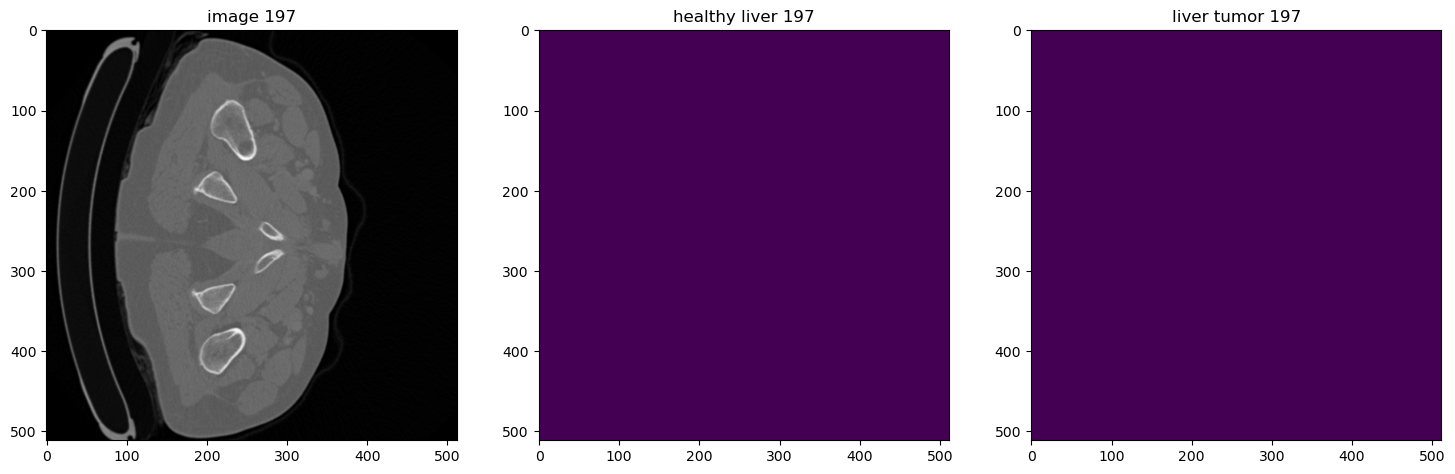

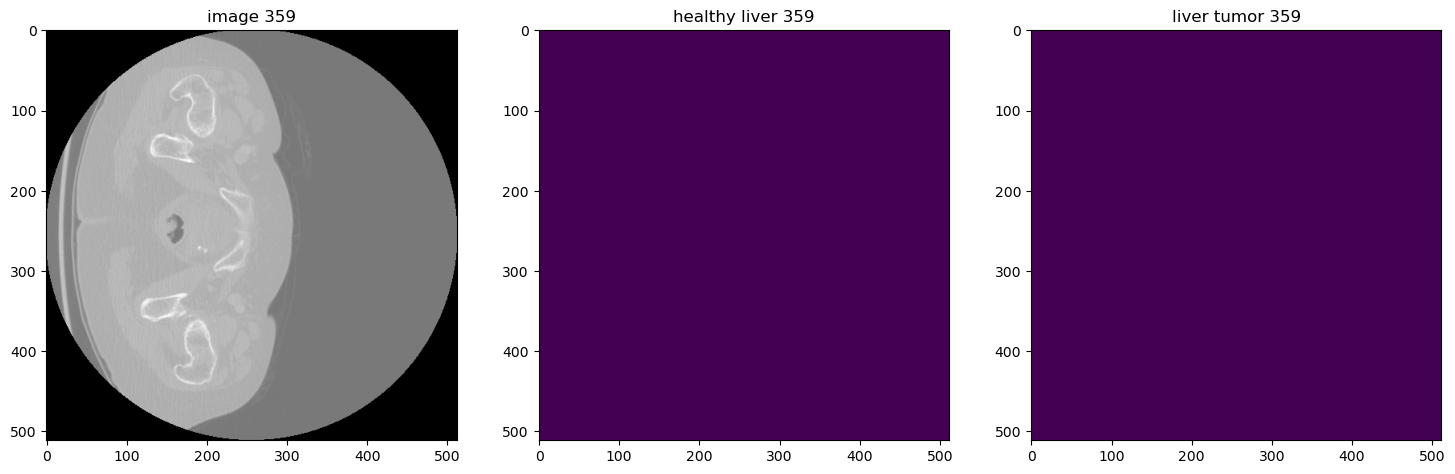

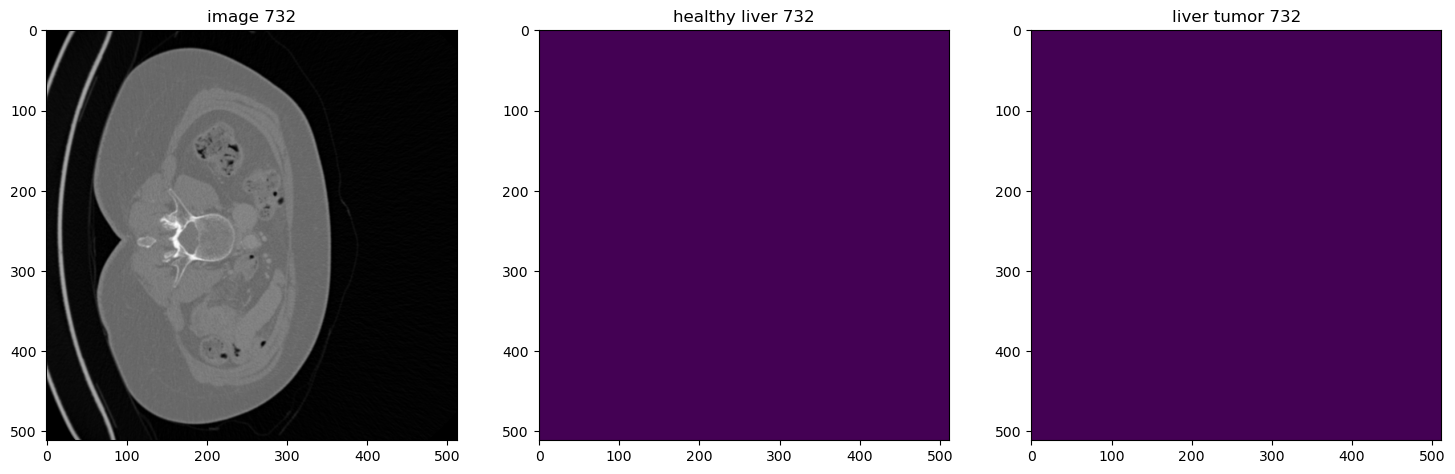

In [14]:
# display properties
num_disp_data = 3
disp_size = 6
# randomly samples data to display, need abit luck of luck to find good samples
to_disp = torch.randint(low=0, high=len(raw_dataset), size=(num_disp_data,))
for img_ind in to_disp:
    plt.figure(f"Data {img_ind}", (disp_size * 3, disp_size))
    plt.subplot(1, 3, 1)
    plt.title(f"image {img_ind}")
    plt.imshow(raw_dataset[img_ind]["vol"][:,:,0], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title(f"healthy liver {img_ind}")
    plt.imshow(raw_dataset[img_ind]["seg"][:,:,0] == 1)
    plt.subplot(1, 3, 3)
    plt.title(f"liver tumor {img_ind}")
    plt.imshow(raw_dataset[img_ind]["seg"][:,:,0] == 2)

## Default Transforms

Let's visualize the default transformation that was provided in the original code to understand what was going on.

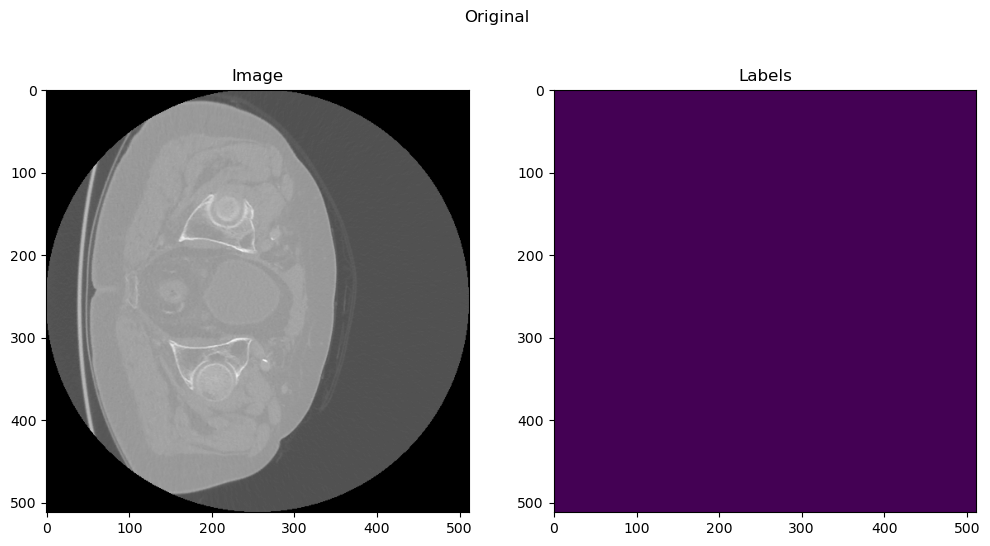

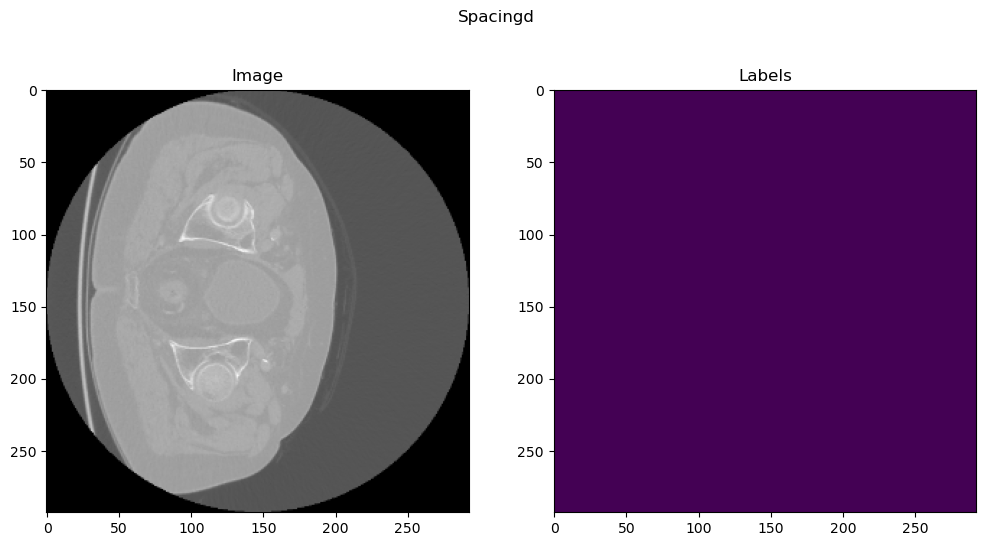

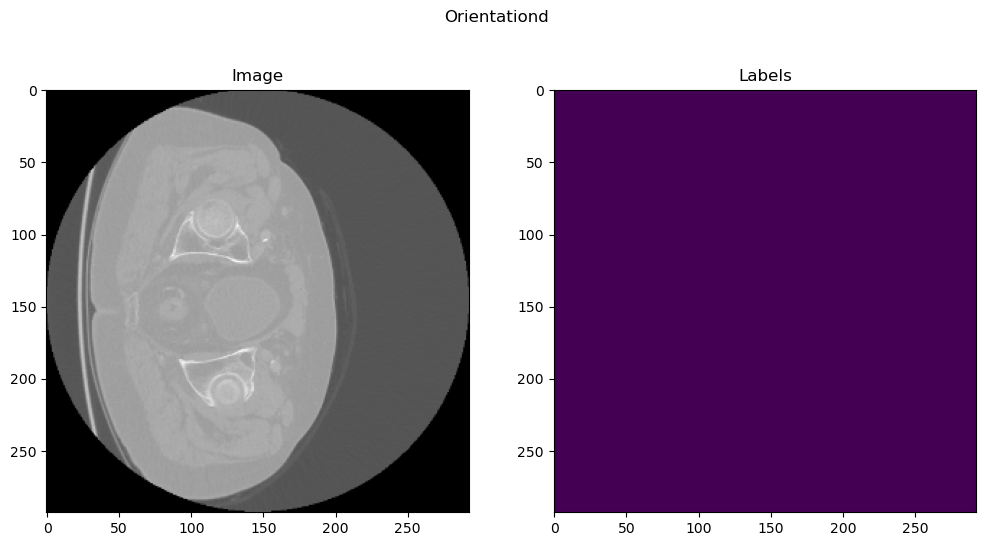

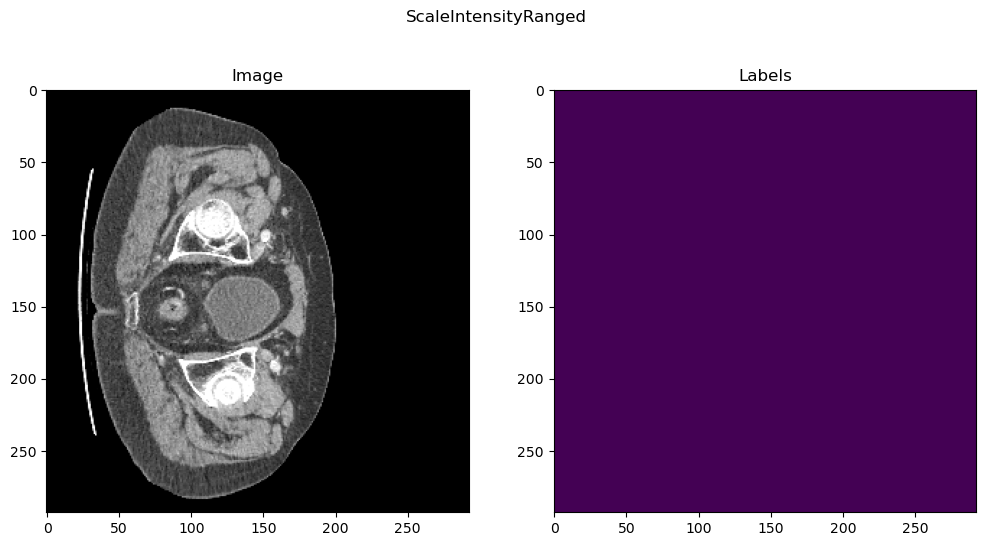

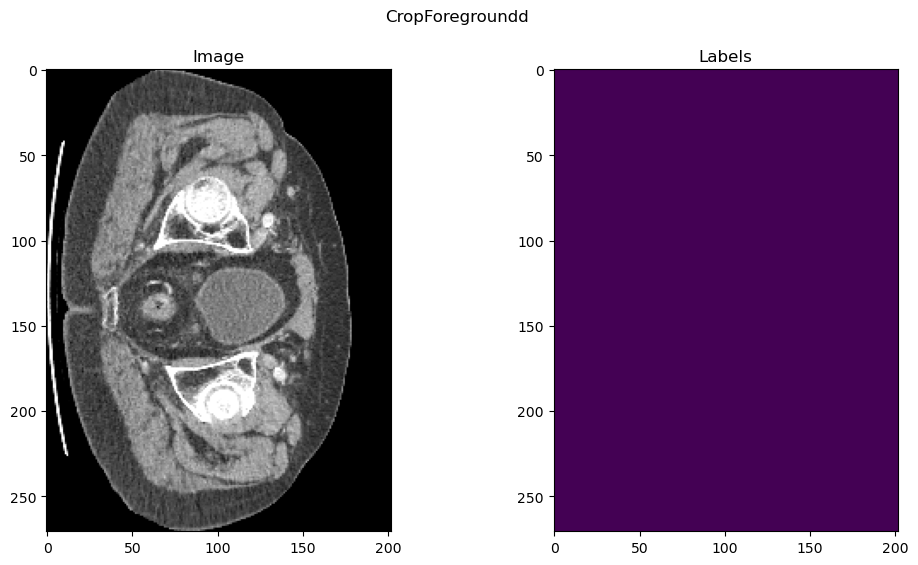

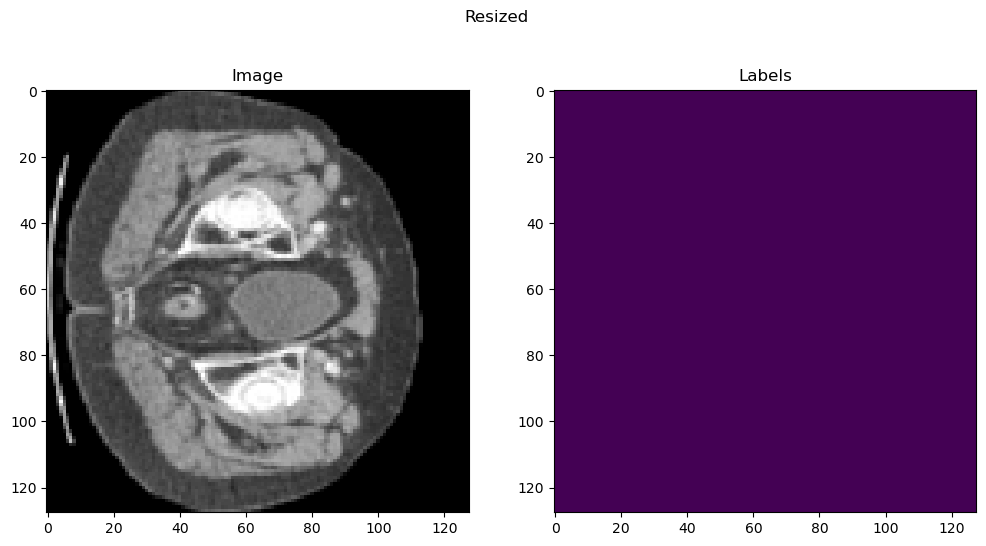

In [15]:
# intermediate transforms we will be visualizing
intermediate_named_transforms = [
    # ("LoadImaged", LoadImaged(keys=["vol", "seg"])), # converts nifti to numpy (won't visualize)
    # ("AddChanneld",AddChanneld(keys=["vol", "seg"])), # adds a channel to the image, basically adds 1 dimension above (won't visualize)
    ("Spacingd", Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest"))), 
    ("Orientationd", Orientationd(keys=["vol", "seg"], axcodes="RAS")),
    ("ScaleIntensityRanged", ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True)), 
    ("CropForegroundd", CropForegroundd(keys=['vol', 'seg'], source_key='vol')),
    ("Resized", Resized(keys=["vol", "seg"], spatial_size=[128,128,64])),   
    # ("ToTensord", ToTensord(keys=["vol", "seg"])), # converts to numpy to tensor for training (won't visualize)
]

# display properties
disp_size = 6
# randomly samples data to display, need abit luck of luck to find good samples
sample_data = raw_dataset[torch.randint(low=0, high=len(raw_dataset), size=(1,))]
# iteratively show each transformation
fig, axs = plt.subplots(1, 2, figsize=(disp_size * 2, disp_size))
fig.suptitle("Original")
axs[0].set_title("Image")
axs[0].imshow(sample_data["vol"][:,:,0], cmap="gray")
axs[1].set_title("Labels")
axs[1].imshow(sample_data["seg"][:,:,0])
sample_data = AddChanneld(keys=["vol", "seg"])(sample_data) # add channel
for xform_name, xform in intermediate_named_transforms:
    sample_data = xform(sample_data)
    fig, axs = plt.subplots(1, 2, figsize=(disp_size * 2, disp_size))
    fig.suptitle(xform_name)
    axs[0].set_title("Image")
    axs[0].imshow(sample_data["vol"][0,:,:,0], cmap="gray")
    axs[1].set_title("Labels")
    axs[1].imshow(sample_data["seg"][0,:,:,0])
plt.show()

## Transforms for UNet 1

Here are the expected additional transforms required for UNet 1 which is supposed to detect both healthy and tumorous liver.

Image: 
- No change

Label: 
- Change segmentation mask to have values 0 for background and 1 for healthy and tumorous liver

In [16]:
default_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True), 
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),   
        ToTensord(keys=["vol", "seg"]),
    ]
)

unet1_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True), 
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),
        # LabelToMaskd(keys=["seg"], select_labels=[1,2]) # set labels [1, 2] to be mask ## did not work well due to non continuous data
        ThresholdIntensityd(keys=["seg"], threshold=1, above=False, cval=1), # convert 2s to 1s in seg mask
        ToTensord(keys=["vol", "seg"], dtype=torch.float16),
    ]
)
# note d versus no d, dictionary vs normal non dictionary

default_dataset = Dataset(data=files, transform=default_transforms)
unet1_dataset = Dataset(data=files, transform=unet1_transforms)

Visualize updated segmentation masks to be used as training/testing inputs

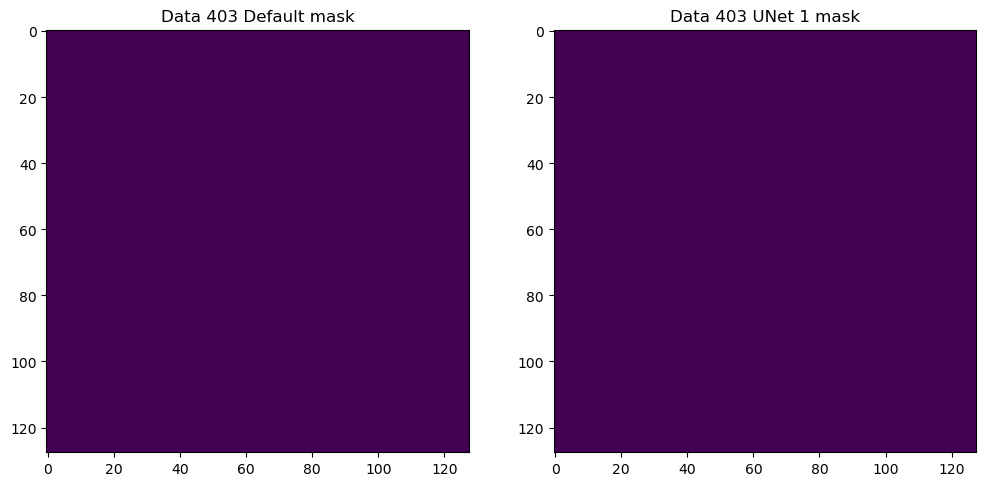

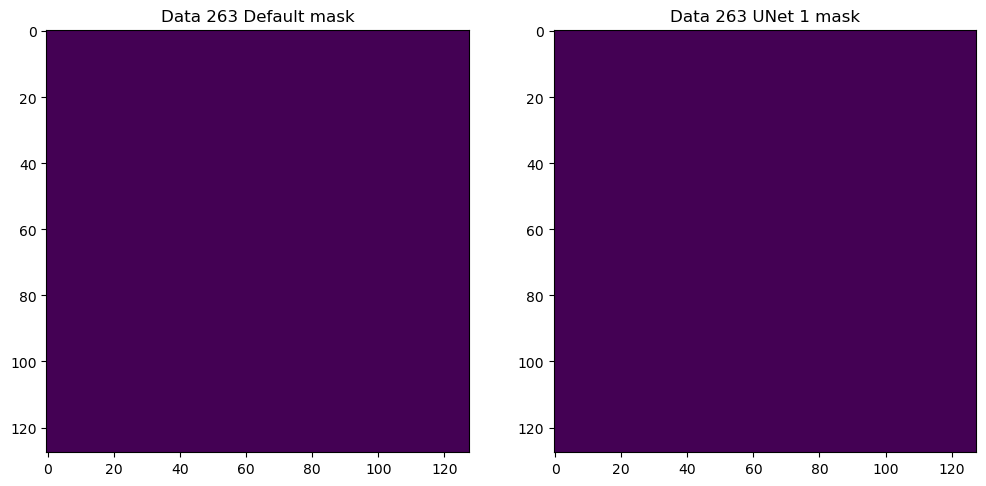

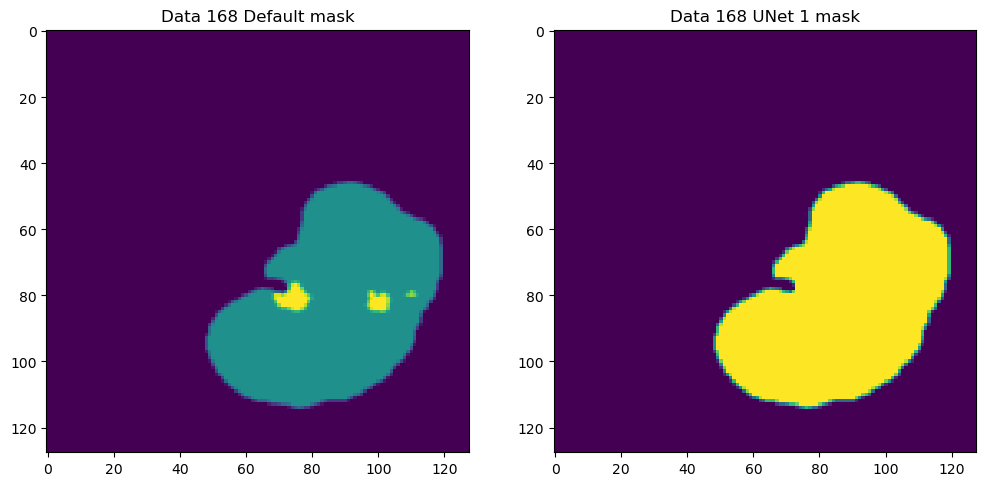

In [17]:
# display properties
disp_size = 6
# selected data which are known to have both tasks
to_disp = torch.tensor([403, 263, 168])
for img_ind in to_disp:
    plt.figure(f"Data {img_ind}", (disp_size * 2, disp_size))
    plt.subplot(1, 2, 1)
    plt.title(f"Data {img_ind} Default mask")
    plt.imshow(default_dataset[img_ind]["seg"][0,:,:,0])
    plt.subplot(1, 2, 2)
    plt.title(f"Data {img_ind} UNet 1 mask")
    plt.imshow(unet1_dataset[img_ind]["seg"][0,:,:,0])

## Transforms for UNet 2

Here are the expected additional transforms required for UNet 2 which is supposed to detect tumorous liver from liver image only.

Image: 
- Mask non liver portion

Label: 
- Change segmentation mask to have values 0 for background healthy and 1 for tumorous liver

In [209]:
unet2_transforms = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        # Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        MaskIntensityd(keys=["vol"], mask_key="seg"), # mask out regions that are not liver
        LabelToMaskd(keys=["seg"], select_labels=[2]), # set labels [2] to be mask
        ScaleIntensityRanged(keys=["vol"], a_min=-200, a_max=200,b_min=0.0, b_max=1.0, clip=True), 
        CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),
        ToTensord(keys=["vol", "seg"], dtype=torch.float16),
    ]
)

unet2_dataset = Dataset(data=files, transform=unet2_transforms)

In [205]:
ind = 524
print(files[ind])
print(unet2_dataset[ind]["vol"].affine)
print(unet2_dataset[ind]["seg"].affine)
print(unet2_dataset[ind]["vol"].shape)
print(unet2_dataset[ind]["seg"].shape)

{'vol': 'data/nifti_files/images/liver_50_0.nii.gz', 'seg': 'data/nifti_files/labels/liver_50_0.nii.gz'}
tensor([[   3.6250,    0.0000,    0.0000, -212.6344],
        [   0.0000,    3.6250,    0.0000, -229.7346],
        [   0.0000,    0.0000,    2.5000, -591.0000],
        [   0.0000,    0.0000,    0.0000,    1.0000]])
tensor([[4.0000, 0.0000, 0.0000, 2.5000],
        [0.0000, 4.0000, 0.0000, 2.5000],
        [0.0000, 0.0000, 1.0000, 1.0000],
        [0.0000, 0.0000, 0.0000, 1.0000]])
torch.Size([1, 128, 128, 64])
torch.Size([1, 128, 128, 64])


Visualize updated image and segmentation masks to be used as training/testing inputs

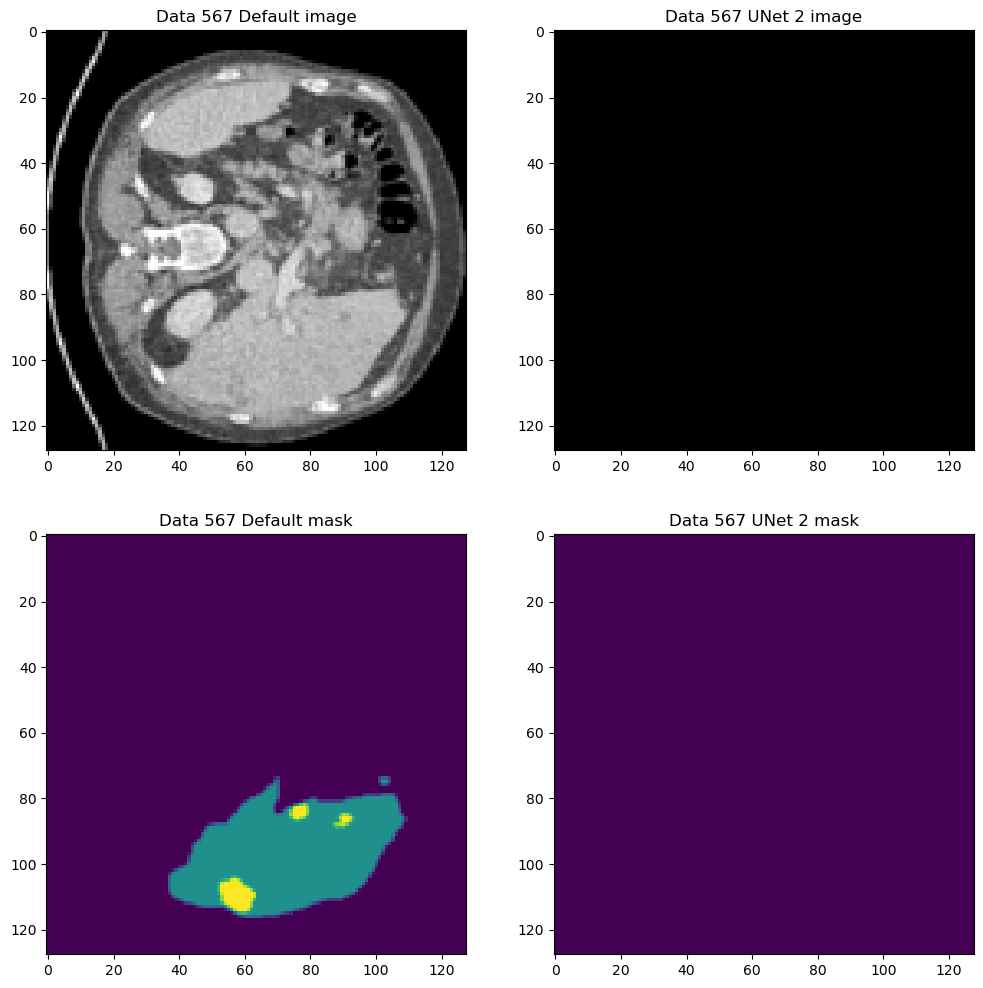

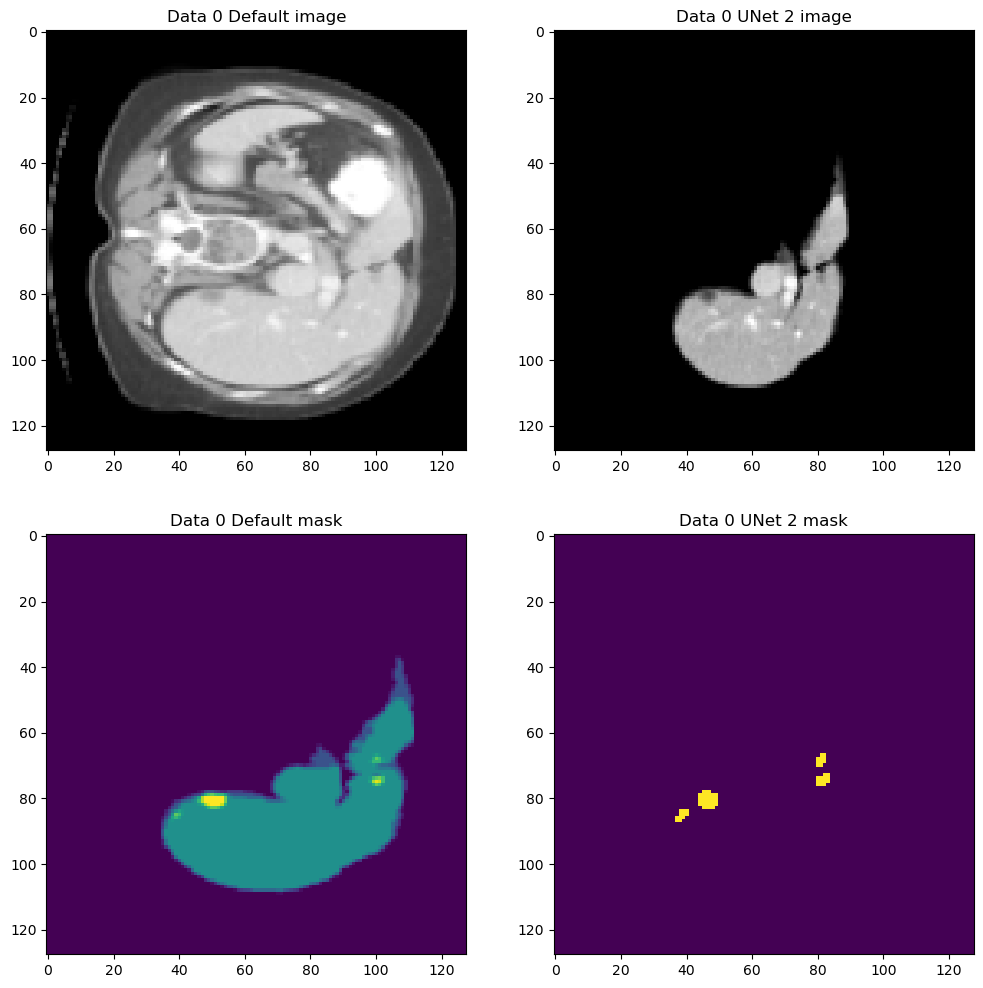

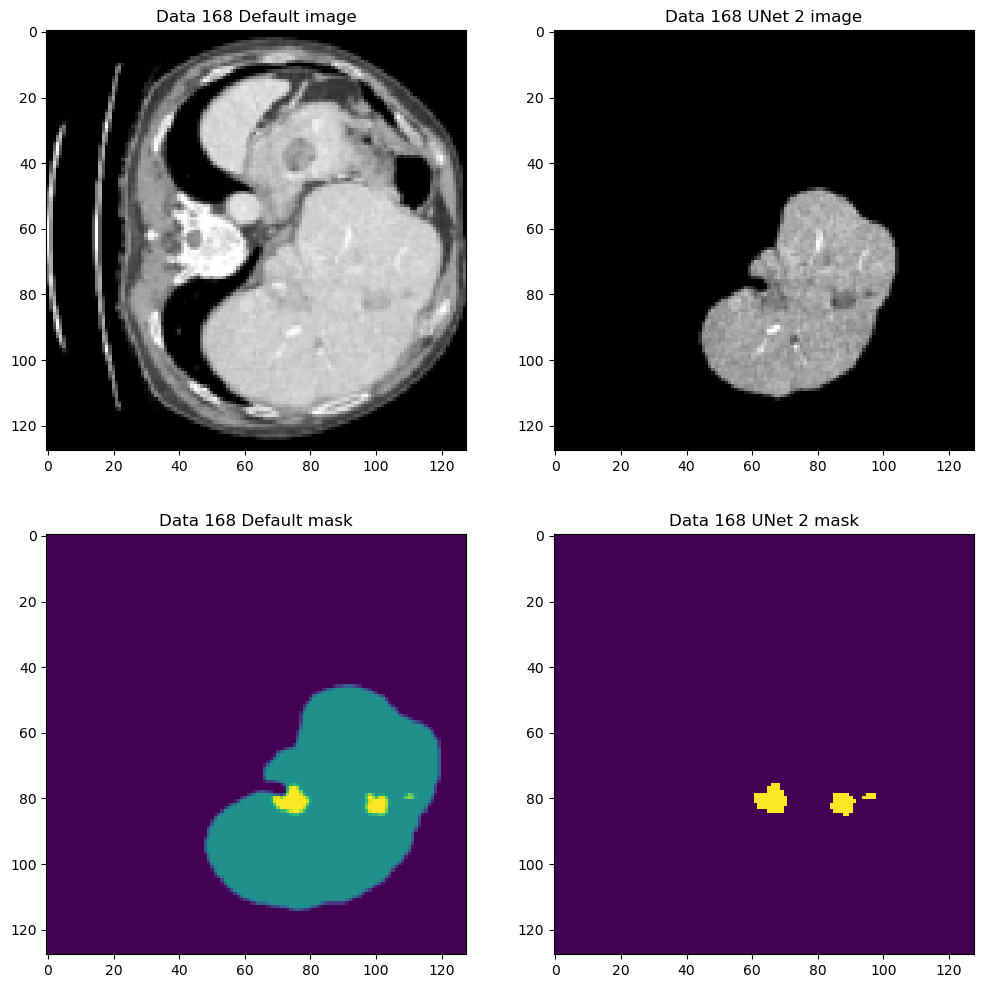

In [95]:
# display properties
disp_size = 6
# selected data which are known to have both tasks
to_disp = [(567, 0), (0, 57), (168, 0)]
for img_ind, img_depth in to_disp:
    plt.figure(f"Data {img_ind}", (disp_size * 2, disp_size * 2))
    plt.subplot(2, 2, 1)
    plt.title(f"Data {img_ind} Default image")
    plt.imshow(default_dataset[img_ind]["vol"][0,:,:,img_depth], cmap='gray')
    plt.subplot(2, 2, 2)
    plt.title(f"Data {img_ind} UNet 2 image")
    plt.imshow(unet2_dataset[img_ind]["vol"][0,:,:,img_depth], cmap='gray')
    plt.subplot(2, 2, 3)
    plt.title(f"Data {img_ind} Default mask")
    plt.imshow(default_dataset[img_ind]["seg"][0,:,:,img_depth])
    plt.subplot(2, 2, 4)
    plt.title(f"Data {img_ind} UNet 2 mask")
    plt.imshow(unet2_dataset[img_ind]["seg"][0,:,:,img_depth])

Subsampling of 2nd dataset

Rationale: Mostly empty data given to 2nd net, creating data imbalance. Try to fix by removing totally empty data first. Save indexes for non empty data to file.

In [210]:
dir = 'data/nifti_files/'
ind_file_name = 'unet2_indexes'

def find_non_empty_data_pts(dataset):
    data_size = len(dataset)
    pbar = tqdm(enumerate(dataset))
    non_empty_inds = []
    for i, data_pt in pbar:
        if not torch.all(~data_pt["seg"].bool()):
            non_empty_inds.append(i)
        pbar.set_description(f"Processing {i}/{data_size} files: Non_empty_ind_count={len(non_empty_inds)}")
    return non_empty_inds

filtered_data = find_non_empty_data_pts(unet2_dataset)
print(filtered_data)
np.save(dir + ind_file_name, np.array(filtered_data))

Processing 847/848 files: Non_empty_ind_count=225: : 848it [08:43,  1.62it/s]

[0, 7, 8, 9, 10, 17, 18, 19, 20, 28, 29, 38, 39, 40, 47, 48, 49, 86, 87, 88, 101, 102, 103, 104, 110, 111, 112, 113, 121, 122, 131, 132, 133, 140, 141, 142, 152, 153, 154, 166, 167, 168, 207, 208, 209, 217, 218, 219, 220, 221, 226, 227, 240, 241, 242, 245, 246, 247, 252, 253, 258, 259, 265, 266, 271, 272, 277, 283, 300, 306, 307, 308, 309, 311, 312, 313, 314, 315, 322, 328, 329, 330, 331, 337, 338, 346, 354, 355, 362, 363, 364, 375, 376, 389, 399, 400, 401, 409, 415, 417, 418, 423, 424, 428, 436, 437, 442, 443, 444, 456, 457, 458, 459, 461, 462, 463, 464, 471, 472, 474, 475, 476, 479, 480, 483, 484, 485, 488, 489, 497, 500, 503, 504, 506, 507, 519, 520, 521, 522, 523, 526, 528, 529, 531, 532, 533, 537, 540, 545, 548, 551, 558, 559, 562, 565, 567, 571, 578, 580, 582, 584, 585, 595, 596, 597, 602, 607, 609, 613, 615, 621, 622, 623, 626, 630, 637, 638, 651, 655, 660, 661, 662, 663, 670, 672, 678, 679, 680, 705, 706, 707, 725, 726, 727, 733, 734, 735, 736, 760, 761, 767, 768, 769, 770, 784

Load indexes from file

In [211]:
filtered_data = np.load(dir + ind_file_name + '.npy').tolist()

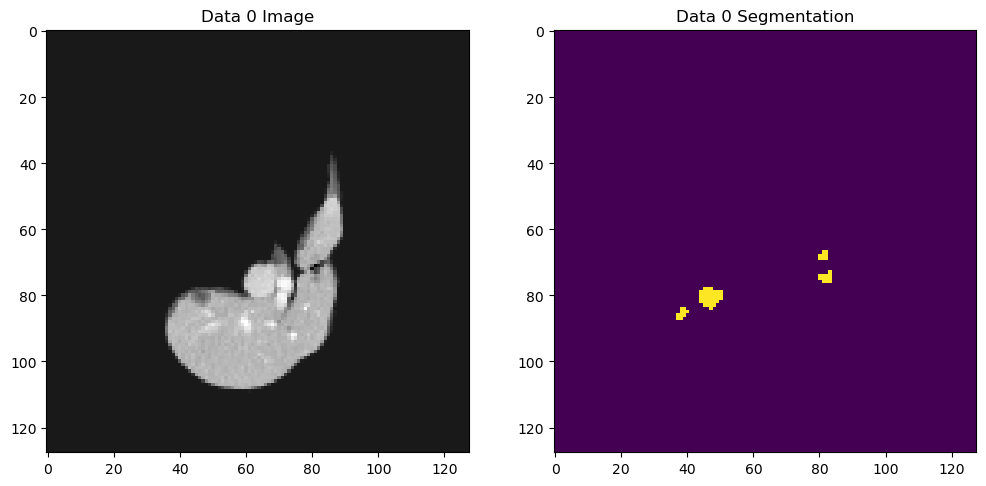

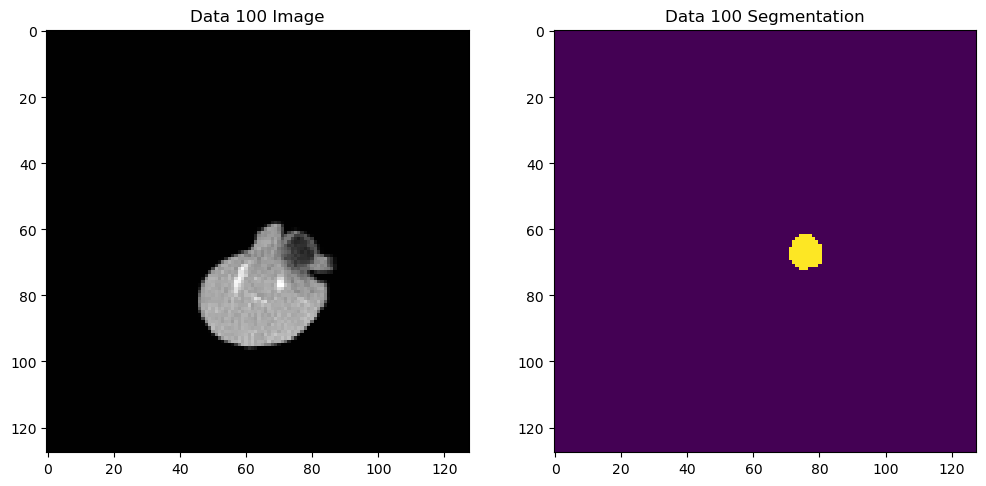

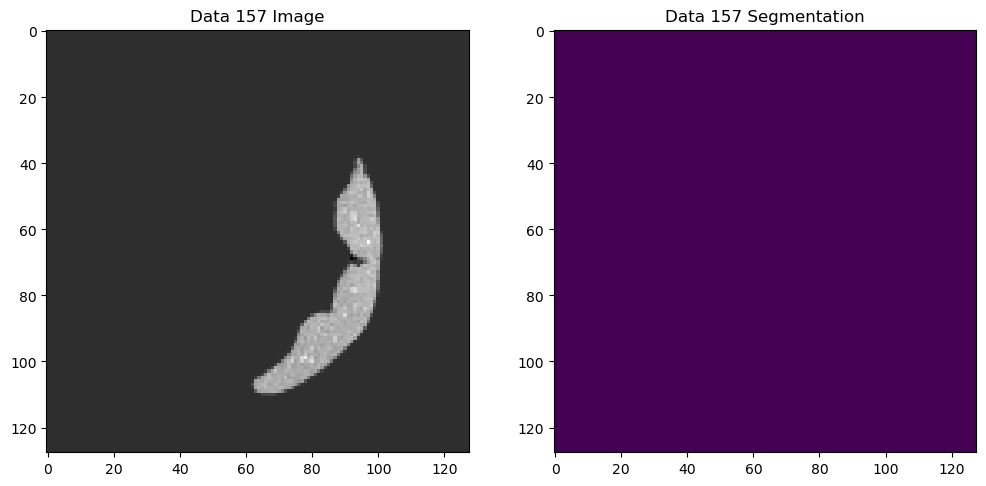

In [213]:
unet2_filtered_dataset = unet2_dataset[filtered_data]

# display properties
disp_size = 6
# selected data which are known to have both tasks
to_disp = [(0, 57), (100, 0), (157, 0)]
for img_ind, img_depth in to_disp:
    plt.figure(f"Data {img_ind}", (disp_size * 2, disp_size * 2))
    plt.subplot(1, 2, 1)
    plt.title(f"Data {img_ind} Image")
    plt.imshow(unet2_filtered_dataset[img_ind]["vol"][0,:,:,img_depth], cmap='gray')
    plt.subplot(1, 2, 2)
    plt.title(f"Data {img_ind} Segmentation")
    plt.imshow(unet2_filtered_dataset[img_ind]["seg"][0,:,:,img_depth])

# Check problematic affines

In [4]:
in_dir_images_full = 'data/nifti_files/images_full/'
in_dir_labels_full = 'data/nifti_files/labels_full/'

# package files and match inputs with output
image_files = sorted(glob(in_dir_images_full + "/*.nii.gz")) # sorted by name to ensure match
label_files = sorted(glob(in_dir_labels_full + "/*.nii.gz"))
# sanity check: ensure len same
assert len(image_files) == len(label_files)
# create dict for volume and segmentation
files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(image_files, label_files)]

# create dataset from files without any additional transforms
raw_dataset = Dataset(data=files, transform=LoadImaged(keys=["vol", "seg"])) # LoadImaged reads nifti file and convert to numpy
data_loader = DataLoader(raw_dataset, batch_size=1)

# find for problematic affines
uneq_affines = []
for ind, data_pt in enumerate(data_loader):
    if not torch.all(data_pt["vol"].affine == data_pt["seg"].affine):
        uneq_affines.append(ind)

# print all problematic
print("Problematic idiots:")
print(uneq_affines)

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-15 18:46:20,357 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-15 18:46:23,059 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-15 18:46:32,591 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-15 18:46:35,053 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-15 18:46:37,573 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
Problematic idiots:
[3, 6, 29, 36, 74, 75, 77, 78, 79, 115, 116, 127, 128, 130]


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-16 00:40:36,774 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


2023-04-16 00:40:42,227 - pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
torch.Size([1, 1, 128, 128, 64])


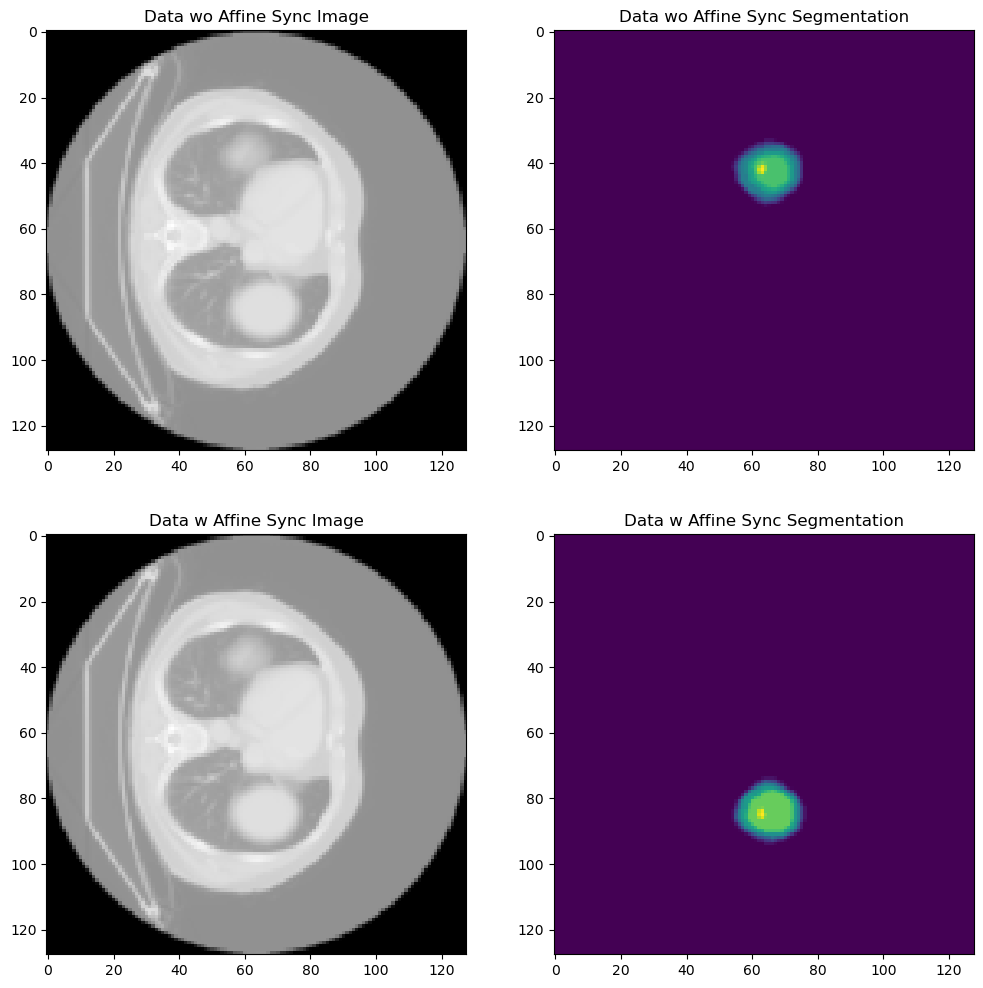

In [34]:
from grp_transforms import ForceSyncAffined

scaling_wo_affine_sync = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),
    ]
)

scaling_w_affine_sync = Compose(
    [
        LoadImaged(keys=["vol", "seg"]),
        ForceSyncAffined(keys=["seg"], source_key="vol"),
        EnsureChannelFirstd(keys=["vol", "seg"]),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        Spacingd(keys=["vol", "seg"], pixdim=(1.5,1.5,1.0), mode=("bilinear", "nearest")),
        Resized(keys=["vol", "seg"], spatial_size=[128,128,64]),    
    ]
)

dataloader_scaling_wo_affine_sync = DataLoader(Dataset(data=files[74:76], transform=scaling_wo_affine_sync), batch_size=1)
dataloader_scaling_w_affine_sync = DataLoader(Dataset(data=files[74:76], transform=scaling_w_affine_sync), batch_size=1)

data_scaling_wo_affine_sync = first(dataloader_scaling_wo_affine_sync)
data_scaling_w_affine_sync = first(dataloader_scaling_w_affine_sync)

print(data_scaling_wo_affine_sync["vol"].shape)

disp_size = 6
plt.figure(f"Data", (disp_size * 2, disp_size * 2))
plt.subplot(2, 2, 1)
plt.title(f"Data wo Affine Sync Image")
plt.imshow(data_scaling_wo_affine_sync["vol"][0,0,:,:,45], cmap='gray')
plt.subplot(2, 2, 2)
plt.title(f"Data wo Affine Sync Segmentation")
plt.imshow(data_scaling_wo_affine_sync["seg"][0,0,:,:,45])
plt.subplot(2, 2, 3)
plt.title(f"Data w Affine Sync Image")
plt.imshow(data_scaling_w_affine_sync["vol"][0,0,:,:,45], cmap='gray')
plt.subplot(2, 2, 4)
plt.title(f"Data w Affine Sync Segmentation")
plt.imshow(data_scaling_w_affine_sync["seg"][0,0,:,:,45])